In [12]:
import requests
import pprint
import pandas as pd
import json
from urllib.parse import urlparse
import urllib
import re
from tqdm import tqdm
import time

## Data Acquisition

### English Language Only

In [26]:
#JSON Escape Error fix by Blairg23
#https://stackoverflow.com/questions/1505454/python-json-loads-chokes-on-escapes
def fix_JSON(json_message=None):
    result = None
    try:        
        result = json.loads(json_message)
    except Exception as e:      
        # Find the offending character index:
        idx_to_replace = int(str(e).split(' ')[-1].replace(')', ''))        
        # Remove the offending character:
        json_message = list(json_message)
        json_message[idx_to_replace] = ' '
        new_message = ''.join(json_message)     
        return fix_JSON(json_message=new_message)
    return result

In [31]:
#Input fixed parameters
parameters = {
    "query": '"belt%20and%20road"OR"one%20belt%20one%20road"%20sourcelang:eng',
    "startdatetime": 20170525000000,
    "enddatetime": 20170525235959,
    "format": "JSON",
    "maxrecords": 250,
    "sort": "DateDesc",
    "mode": "ToneChart"
}
url = "https://api.gdeltproject.org/api/v2/doc/doc?" + urllib.parse.urlencode(parameters, safe='%():+')
response = requests.get(url)


In [32]:
output = fix_JSON(response.content.decode('utf8'))
pprint.pprint(output['tonechart'])

[{'bin': -8,
  'count': 1,
  'toparts': [{'title': 'Sinkhole causes road closure in Bakersfield , '
                        'California -- Earth Changes',
               'url': 'https://www.sott.net/article/351957-Sinkhole-causes-road-closure-in-Bakersfield-California'}]},
 {'bin': -7,
  'count': 3,
  'toparts': [{'title': 'China denies UN report on CPEC',
               'url': 'http://www.nerve.in/news:2535003921070'},
              {'title': 'Pakistan captures Taliban leader blamed for three '
                        'bombings in restive southwest',
               'url': 'http://www.businessinsider.com/r-pakistan-captures-taliban-leader-blamed-for-three-bombings-in-restive-southwest-2017-5'},
              {'title': 'China dismisses Moody downgrade as  inappropriate  ',
               'url': 'http://en.people.cn/n3/2017/0525/c90000-9220520.html'}]},
 {'bin': -6,
  'count': 8,
  'toparts': [{'title': 'China denies UN report on CPEC',
               'url': 'http://www.business-standard

In [ ]:
#Input fixed parameters
parameters = {
    "query": '"belt%20and%20road"OR"one%20belt%20one%20road"%20sourcelang:eng',
    "startdatetime": 20170101000000,
    "enddatetime": 20170101235959,
    "format": "JSON",
    "maxrecords": 250,
    "sort": "DateDesc",
    "mode": "ToneChart"
}

for year in range(2023,2024):
    results[str(year)] = []
    
    #Range Array for parameters
    r = pd.date_range(str(year)+'0101',str(year)+'1231')
    r = r.format(formatter=lambda x: x.strftime('%Y%m%d'))
    #Input parameters according to dates
    for day in tqdm(range(len(r))):
        time.sleep(5.5)
        parameters["startdatetime"] = r[day] + '000000'
        parameters["enddatetime"] = r[day] + '235959'
        
        url = "https://api.gdeltproject.org/api/v2/doc/doc?" + urllib.parse.urlencode(parameters, safe='%():+')
        response = requests.get(url)
        
        #Prevent JSON escape errors
        output = fix_JSON(response.content.decode('utf8'))
        if len(output)!=0:
            for length in range(len(output['tonechart'])):
                if len(output['tonechart'][length]['toparts']) !=0:
                    for num_of_articles in range(len(output['tonechart'][length]['toparts'])):
                        details = {"title": output['tonechart'][length]['toparts'][num_of_articles]['title'],
                                    "url": output['tonechart'][length]['toparts'][num_of_articles]['url'],
                                    "date": r[day],
                                    "tone": output['tonechart'][length]['bin']}
                        results[str(year)].append(details)

In [117]:
# Save raw JSON data
#with open('./Final Data/1 - raw_data.json', 'w', encoding='utf-8') as f:
#        json.dump(results, f, indent=4, default=str)

#### Label articles with domain and country source using API

In [119]:
parameters = {
    "query": 'domain:global.chinadaily.com.cn',
    "format": "JSON",
    "maxrecords": 1,
    "mode": "ArtList"
}

In [127]:
unlabelled_domains = []
labelled_domains = {}
unlabelled_count = 0

In [139]:
from time import sleep
for year in range(2019,2024):
    year = str(year)
    for num in tqdm(range(len(results[year]))):
        #Get URL domain
        domain = str(urlparse(results[year][num]['url']).netloc)
        domain = re.sub(r'www.', '', domain)

        results[year][num]['domain'] = domain

        #Check domain with unlabelled domains first (Smaller dataset)
        if domain in unlabelled_domains:
            unlabelled_count+=1

        #Check domain with local data
        elif domain in labelled_domains:
            results[year][num]['sourcecountry'] = labelled_domains[domain]

        else:
            #Get sourcecountry from API
            sleep(5.5)
            parameters['query'] = 'domain:'+ domain
            response = requests.get("https://api.gdeltproject.org/api/v2/doc/doc", params=parameters)
            output = fix_JSON(response.content.decode('utf8'))
            if len(output) !=0:
                results[year][num]['sourcecountry'] = output['articles'][0]['sourcecountry']
                labelled_domains[domain] = output['articles'][0]['sourcecountry']
            else:
                unlabelled_domains.append(domain)
                unlabelled_count+=1

100%|██████████| 15147/15147 [25:44<00:00,  9.80it/s] 


In [140]:
#with open('./Final Data/2 - sourcecountry.json', 'w', encoding='utf-8') as f:
        #json.dump(results, f, indent=4, default=str)

### All languages for NATO

In [3]:
nato_countries_short = ['AL', 'BE', 'BU', 'CA', 'HR', 'EZ', 'DA', 'EN', 'FI', 'FR',
                        'GM', 'GR', 'HU', 'IC', 'IT', 'LG', 'LH', 'LU', 'MJ', 'NL',
                        'MK', 'NO', 'PL', 'PO', 'RO', 'LO', 'SI', 'SP', 'TU', 'GB',
                        'US']

In [8]:
import urllib.parse
parameters["query"] = '"belt and road"+"one belt one road" (sourcecountry:%s)' %' OR sourcecountry:'.join(nato_countries_short[20:30])#Query to search
url = "https://api.gdeltproject.org/api/v2/doc/doc/?" + urllib.parse.urlencode(parameters, safe='():+')
response = requests.get(url)

In [ ]:
import urllib.parse

#Input fixed parameters
parameters = {
"query": '"belt and road"+"one belt one road"', #Query to search
"startdatetime": '',
"enddatetime": '',
"format": "JSON",
"maxrecords": 250,
"sort": "DateDesc",
"mode": "ToneChart"}

nato_countries_short = ['AL', 'BE', 'BU', 'CA', 'HR', 'EZ', 'DA', 'EN', 'FI', 'FR',
                        'GM', 'GR', 'HU', 'IC', 'IT', 'LG', 'LH', 'LU', 'MJ', 'NL',
                        'MK', 'NO', 'PL', 'PO', 'RO', 'LO', 'SI', 'SP', 'TU', 'GB',
                        'US']


for x in [0,10,20]:
    for year in range(2017,2024):
        results[str(year)] = []
        

        #Range Array for parameters
        r = pd.date_range(str(year)+'0101',str(year)+'1231')
        r = r.format(formatter=lambda x: x.strftime('%Y%m%d'))

        

        #Input parameters according to dates
        for day in tqdm(range(len(r))):
            time.sleep(5.5)
            parameters["startdatetime"] = r[day] + '000000'
            parameters["enddatetime"] = r[day] + '235959'
            
            parameters["query"] = '"belt and road"+"one belt one road" (sourcecountry:%s)' %' OR sourcecountry:'.join(nato_countries_short[x:x+10])#Query to search
            url = "https://api.gdeltproject.org/api/v2/doc/doc/?" + urllib.parse.urlencode(parameters, safe='():+')
            response = requests.get(url)
            
            #Prevent JSON escape errors
            output = fix_JSON(response.content.decode('utf8'))
            if len(output)!=0:
                for length in range(len(output['tonechart'])):
                    if len(output['tonechart'][length]['toparts']) !=0:
                        for num_of_articles in range(len(output['tonechart'][length]['toparts'])):
                            details = {"title": output['tonechart'][length]['toparts'][num_of_articles]['title'],
                                        "url": output['tonechart'][length]['toparts'][num_of_articles]['url'],
                                        "date": r[day],
                                        "tone": output['tonechart'][length]['bin']}
                            results[str(year)].append(details)

In [564]:
with open('./additional_data/nato_results2.json', 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=4, default=str)

In [366]:
from urllib.parse import urlparse
import re

unlabelled_domains = []
labelled_domains = {}
unlabelled_count = 0

parameters = {
    "query": 'domain:global.chinadaily.com.cn',
    "format": "JSON",
    "maxrecords": 1,
    "mode": "ArtList"
}

In [539]:
year=2023
year = str(year)
for num in range(len(results[year])):
    #Get URL domain
    domain = str(urlparse(results[year][num]['url']).netloc)
    domain = re.sub(r'www.', '', domain)

    results[year][num]['domain'] = domain

    #Check domain with unlabelled domains first (Smaller dataset)
    if domain in unlabelled_domains:
        unlabelled_count+=1

    #Check domain with local data
    elif domain in labelled_domains:
        results[year][num]['sourcecountry'] = labelled_domains[domain]

    else:
        #Get sourcecountry from API
        parameters['query'] = 'domain:'+ domain
        response = requests.get("https://api.gdeltproject.org/api/v2/doc/doc", params=parameters)
        output = fix_JSON(response.content.decode('utf8'))
        if len(output) !=0:
            results[year][num]['sourcecountry'] = output['articles'][0]['sourcecountry']
            labelled_domains[domain] = output['articles'][0]['sourcecountry']
        else:
            unlabelled_domains.append(domain)
            unlabelled_count+=1

In [34]:
year = str(2017)
for num in range(len(results[year])):
    country = results[year][num]['sourcecountry']
    tone = results[year][num]['tone']
    country_df.loc[(country_df['Country']==country) & (country_df['Year']==str(year)), 'Average Tone'] += int(tone)

country_df["Average Tone"]=country_df["Average Tone"].astype(float)
for num in range(len(country_df)):
    country_df.iat[num,4] = country_df.iat[num,4] / country_df.iat[num,1]

In [52]:
country_df = pd.DataFrame(columns=['Country','Count','Year'])
country_df["Count"]=country_df["Count"].astype(float)
for year in range(2017,2023):
    country_count = {}
    year = str(year)
    for i in range(len(results[year])):
        try:
            country_count[results[year][i]['sourcecountry']] +=1
        except:
            country_count[results[year][i]['sourcecountry']] =1

    country_count = sorted(country_count.items(), reverse=True, key=lambda item: item[1])
    df = pd.DataFrame.from_dict(country_count).set_axis(['Country', 'Count'], axis=1)
    df['Year'] = year
    country_df= pd.concat([country_df,df])

country_df.index +=1

### All languages for NATO (With extra queries)

In [88]:
#Input fixed parameters
parameters = {
"query": '"belt and road"OR"one belt one road"OR"la Ceinture et la Route"OR"Nuova via della seta"OR"Seidenstraßen"%20(sourcecountry:FR%20OR%20sourcecountry:GM%20OR%20sourcecountry:IT%20OR%20sourcecountry:US%20OR%20sourcecountry:UK)',
"startdatetime": '',
"enddatetime": '',
"format": "JSON",
"maxrecords": 250,
"sort": "DateDesc",
"mode": "ToneChart"}

In [38]:
import urllib.parse

nato_countries_cut = ['FR','GM','IT','US','GB','SW','DA','TU','SP','PL']


for year in range(2017,2024):
    results[str(year)] = []
    

    #Range Array for parameters
    r = pd.date_range(str(year)+'0101',str(year)+'1231')
    r = r.format(formatter=lambda x: x.strftime('%Y%m%d'))

    

    #Input parameters according to dates
    for day in tqdm(range(len(r))):
        time.sleep(5.5)
        parameters["startdatetime"] = r[day] + '000000'
        parameters["enddatetime"] = r[day] + '235959'
        
        #parameters["query"] = '"belt and road"+"one belt one road" (sourcecountry:%s)' %' OR sourcecountry:'.join(nato_countries_cut)#Query to search
        url = "https://api.gdeltproject.org/api/v2/doc/doc/?" + urllib.parse.urlencode(parameters, safe='():+')
        response = requests.get(url)
        
        #Prevent JSON escape errors
        output = fix_JSON(response.content.decode('utf8'))
        if len(output)!=0:
            for length in range(len(output['tonechart'])):
                if len(output['tonechart'][length]['toparts']) !=0:
                    for num_of_articles in range(len(output['tonechart'][length]['toparts'])):
                        details = {"title": output['tonechart'][length]['toparts'][num_of_articles]['title'],
                                    "url": output['tonechart'][length]['toparts'][num_of_articles]['url'],
                                    "date": r[day],
                                    "tone": output['tonechart'][length]['bin']}
                        results[str(year)].append(details)

 67%|██████▋   | 245/365 [30:30<14:56,  7.47s/it]


IndexError: list assignment index out of range

In [44]:
unlabelled_domains = []
with open('labelled_domains.json') as f:
        labelled_domains = json.load(f)
unlabelled_count = 0

parameters = {
    "query": 'domain:global.chinadaily.com.cn',
    "format": "JSON",
    "maxrecords": 1,
    "mode": "ArtList"
}

In [58]:
year=2023
year = str(year)
for num in (range(0,len(results[year]))):
    #Get URL domain
    domain = str(urlparse(results[year][num]['url']).netloc)
    domain = re.sub(r'www.', '', domain)

    results[year][num]['domain'] = domain

    #Check domain with unlabelled domains first (Smaller dataset)
    if domain in unlabelled_domains:
        unlabelled_count+=1

    #Check domain with local data
    elif domain in labelled_domains:
        results[year][num]['sourcecountry'] = labelled_domains[domain]

    else:
        #Get sourcecountry from API
        parameters['query'] = 'domain:'+ domain
        response = requests.get("https://api.gdeltproject.org/api/v2/doc/doc", params=parameters)
        output = fix_JSON(response.content.decode('utf8'))
        if len(output) !=0:
            results[year][num]['sourcecountry'] = output['articles'][0]['sourcecountry']
            labelled_domains[domain] = output['articles'][0]['sourcecountry']
        else:
            unlabelled_domains.append(domain)
            unlabelled_count+=1

In [64]:
results['2022']

[{'title': 'Severe weather dangers mark 1st days of 2022',
  'url': 'http://www.msn.com/en-us/weather/topstories/severe-weather-dangers-mark-1st-days-of-2022/vi-AAS1Kg1',
  'date': '20220101',
  'tone': -25,
  'domain': 'msn.com',
  'sourcecountry': 'United States'},
 {'title': 'Omicidio a Napoli | ucciso boss del clan Iadonisi | è la faida di Fuorigrotta con il clan Troncone',
  'url': 'https://www.zazoom.it/2022-01-01/omicidio-a-napoli-ucciso-boss-del-clan-iadonisi-e-la-faida-di-fuorigrotta-con-il-clan-troncone/10100487/',
  'date': '20220101',
  'tone': -24,
  'domain': 'zazoom.it',
  'sourcecountry': 'Italy'},
 {'title': 'Omicron New Year cocktail : Sorrow , fear , hope for 2022',
  'url': 'https://www.pressenterpriseonline.com/apnews/omicrons-new-years-cocktail-sorrow-fear-hope-for-2022',
  'date': '20220101',
  'tone': -24,
  'domain': 'pressenterpriseonline.com',
  'sourcecountry': 'United States'},
 {'title': 'Severe weather on New Year Eve 2021 in Georgia',
  'url': 'https://w

In [51]:
range(len(results[year]))

range(0, 154812)

## Data pre-processing

In [6]:
with open('./Final Data/2 - sourcecountry.json') as f:
        results = json.load(f)

In [7]:
with open('unlabelled_domains.json') as f:
        unlabelled_domains = json.load(f)

#### Remove duplicates and also low-quality news articles with same titles

In [8]:
#Edited from Remove duplicate from list of dict based on key value by Jean-François Fabre
#https://stackoverflow.com/questions/43319409/remove-duplicates-key-from-list-of-dictionaries-python
def remove_duplicate(list_of_dict):
    done = set()
    result = []
    for d in list_of_dict:
        phrase = " ".join(d['title'].split()[:5]).lower()
        if phrase not in done:
            done.add(phrase)  # note it down for further iterations
            result.append(d)
    return result

In [10]:
results_removed_duplicates = {}
for year in range(2017,2024):
    print(str(year)+" Number of articles before: " + str(len(results[str(year)])))
    results_removed_duplicates[str(year)] = remove_duplicate(results[str(year)])
    print(str(year)+" Number of articles after: " + str(len(results_removed_duplicates[str(year)])))

print("\nNumber of duplicated news articles removed: ", sum(len(results[year]) for year in results)-
                                            sum(len(results_removed_duplicates[year]) for year in results_removed_duplicates))
                                        
print("Number of news articles before pre-processing: ", sum(len(results[year]) for year in results))

print("Number of news articles after pre-processing: ", sum(len(results_removed_duplicates[year]) for year in results_removed_duplicates))


2017 Number of articles before: 33683
2017 Number of articles after: 18890
2018 Number of articles before: 35333
2018 Number of articles after: 19506
2019 Number of articles before: 34471
2019 Number of articles after: 19160
2020 Number of articles before: 24081
2020 Number of articles after: 12922
2021 Number of articles before: 27435
2021 Number of articles after: 12973
2022 Number of articles before: 27183
2022 Number of articles after: 11686
2023 Number of articles before: 15147
2023 Number of articles after: 7415

Number of duplicated news articles removed:  94781
Number of news articles before pre-processing:  197333
Number of news articles after pre-processing:  102552


In [16]:
unlabelled_domains_count = {}
labelled_domains_count = {}
for year in range(2017,2024):
    year = str(year)
    for num in range(len(results[year])):
        if results[year][num]['domain'] in unlabelled_domains:
            try:
                unlabelled_domains_count[results[year][num]['domain']] +=1
            except:
                unlabelled_domains_count[results[year][num]['domain']] = 1
        try:
            if results[year][num]['sourcecountry'] == "":
                try:
                    unlabelled_domains_count[results[year][num]['domain']] +=1
                except:
                    unlabelled_domains_count[results[year][num]['domain']] = 1
            else:
                try:
                    labelled_domains_count[results[year][num]['domain']] +=1
                except:
                    labelled_domains_count[results[year][num]['domain']] = 1
        except:
            pass

#### Sort and convert list to list of dict

In [161]:
unlabelled_domains_count = dict(sorted(unlabelled_domains_count.items(), reverse=True, key=lambda item: item[1]))

In [231]:
unlabelled_domain_dict = [] #Dict for manually labelling domains with 50 or more news articles
for num in range(len(unlabelled_domains_count)):
    details = {'domain': list(unlabelled_domains_count.keys())[num],
                'count': unlabelled_domains_count.get(list(unlabelled_domains_count.keys())[num])}
    unlabelled_domain_dict.append(details)

In [232]:
more_articles = more_count = less_articles = less_count = 0
for num in range(len(unlabelled_domain_dict)):
    if unlabelled_domain_dict[num]['count'] < 50:
        less_articles+= unlabelled_domain_dict[num]['count']
        less_count+= 1
    else:
        more_articles+= unlabelled_domain_dict[num]['count']
        more_count+=1
print(str(less_count) + ' domains with less than 50 news articles: ' + str(less_articles))
print(str(more_count) + ' domains with 50 or more news articles: ' + str(more_articles))

2208 domains with less than 50 news articles: 8967
62 domains with 50 or more news articles: 12689


As manual labelling is time intensive, labelling domains with 50 or more news articles will cover more than half of the unlabelled dataset

#### Domains that are deemed to be invalid
- Domains that consists of reposts of other news articles
- Domains that consistently consists of news articles not relevant to BRI
- Wordpress/Blogs that are not media outlets
- Domains that consists of less than 50 news articles

In [237]:
#Combine manually deemed invalid domains with news articles less than 50
removed_domains = []
removed_domains.extend(manually_removed_domains)
for i in range(0,len(unlabelled_domain_dict)):
    try:
        unlabelled_domain_dict[i]['sourcecountry']
    except:
        if unlabelled_domain_dict[i]['domain'] not in manually_removed_domains:
            removed_domains.append(unlabelled_domain_dict[i]['domain'])

print('Total domains removed: ', len(removed_domains))

Total domains removed:  2224


#### Remove invalid domains based on 'removed_domains' and label respective 'sourcecountry'

In [227]:
results_removed_domains = {}

for year in range(2017,2024):
    year = str(year)
    results_removed_domains[year] = []
    for i in range(len(results[year])):
        if results[year][i]['domain'] not in removed_domains:
            try:
                if results[year][i]['sourcecountry'] == "":
                    results[year][i]['sourcecountry'] = next(item['sourcecountry'] for item in unlabelled_domain_dict if item["domain"] == results[year][i]['domain'])
            except:
                try:
                    results[year][i]['sourcecountry'] = next(item['sourcecountry'] for item in unlabelled_domain_dict if item["domain"] == results[year][i]['domain'])
                except:
                    print(year,i)
            results_removed_domains[year].append(results[year][i])



print("Number of news articles removed: ", sum(len(results[year]) for year in results)-sum(len(results_removed_domains[year]) for year in results_removed_domains))


Number of news articles removed:  11618


In [266]:
with open('labelled_domains.json') as f:
        labelled_domains = json.load(f)

for i in range(len(unlabelled_domain_dict)):
    try:
        labelled_domains[unlabelled_domain_dict[i]['domain']] = unlabelled_domain_dict[i]['sourcecountry']
    except:
        pass

#with open('labelled_domains.json', 'w', encoding='utf-8') as f:
        #json.dump(labelled_domains, f, indent=4, default=str)

In [273]:
#with open('./Final Data/3 - final_data.json', 'w', encoding='utf-8') as f:
        #json.dump(results_removed_domains, f, indent=4, default=str)

## Data Exploration

Run from here for data exploration using saved files

In [3]:
import pandas as pd
import json
import plotly.express as px
import plotly.graph_objects as go
import country_converter as coco

with open('./Final Data/3 - final_data.json') as f:
        final_results = json.load(f)

### Visualise number of articles in each country over the years

In [4]:
country_df = pd.DataFrame(columns=['Country','Count','Year'])
country_df["Count"]=country_df["Count"].astype(float)
for year in range(2017,2024):
    country_count = {}
    year = str(year)
    for i in range(len(final_results[year])):
        try:
            country_count[final_results[year][i]['sourcecountry']] +=1
        except:
            country_count[final_results[year][i]['sourcecountry']] =1

    country_count = sorted(country_count.items(), reverse=True, key=lambda item: item[1])
    df = pd.DataFrame.from_dict(country_count).set_axis(['Country', 'Count'], axis=1)
    df['Year'] = year
    country_df= pd.concat([country_df,df])

country_df.index +=1

In [5]:
#Discrete colours according to range
bins = [0, 10, 50, 500, 1000, 2500, 4000, 10000]
labels = [f"{i}-{j}" for i, j in zip(bins[:-1], bins[1:])]
country_df["Count_range"] = pd.cut(country_df["Count"], bins=bins, labels=labels)

color_scale = {
    "0-10": '#0d0887',
    "10-50": '#46039f',
    "50-500": '#7201a8',
    "500-1000": '#9c179e',
    "1000-2500": '#bd3786',
    "2500-4000": '#d8576b',
    "4000-10000": '#ed7953',
}

fig = px.choropleth(country_df,
                    locations="Country",
                    color="Count_range",
                    hover_data={"Country": False,
                                "Count": True,
                                "Year": False,
                                "Count_range": False},
                    hover_name="Country", # column to add to hover information
                    locationmode="country names",
                    animation_frame="Year",
                    color_discrete_sequence= ['#ed7953','#d8576b','#bd3786','#9c179e','#7201a8','#46039f','#0d0887'],
                    category_orders={"Count_range": ["4000-10000", "2500-4000", "1000-2500", "500-1000", "50-500", "10-50", "0-10"]},
                    )

fig.update_layout(
    autosize=False,
    width=1200,
    height=800,)

fig.show()

### Visualise average tone of each country over the years

#### Calculate average tone each year

In [296]:
country_df['Average Tone'] = 0
for year in range(2017,2024):
    year = str(year)
    total_tone = 0
    for num in range(len(final_results[year])):
        country = final_results[year][num]['sourcecountry']
        tone = final_results[year][num]['tone']
        country_df.loc[(country_df['Country']==country) & (country_df['Year']==str(year)), 'Average Tone'] += int(tone)

country_df["Average Tone"]=country_df["Average Tone"].astype(float)
for num in range(len(country_df)):
    country_df.iat[num,4] = country_df.iat[num,4] / country_df.iat[num,1]

In [7]:
#load csv
country_df = pd.read_csv('./csv/country_df.csv', index_col=0)

In [10]:

fig = px.choropleth(country_df,
                    locations="Country",
                    color="Average Tone",
                    hover_data={"Country": False,
                                "Count": True,
                                "Year": False,
                                "Count_range": False,
                                "Average Tone": True},
                    hover_name="Country", # column to add to hover information
                    locationmode="country names",
                    animation_frame="Year",
                    color_discrete_map=px.colors.sequential.Plasma
                    )

fig.update_layout(
    autosize=False,
    width=1200,
    height=800,)

fig.show()

### Visualise average tone by region

#### Add ISO3 code and Region

In [297]:
# Read csv file
UNSD_region = pd.read_csv('UNSD — Methodology.csv', sep=';')

In [298]:
# create a dictionary that matches each country to its region
region_dict = dict(zip(UNSD_region['ISO-alpha3 Code'], UNSD_region['Region Name']))

# create a dictionary that matches each country to its sub-region
subregion_dict = dict(zip(UNSD_region['ISO-alpha3 Code'], UNSD_region['Sub-region Name']))

# add Taiwan to the region_dict dictionary
region_dict.update({'TWN': 'Asia'})

# add Taiwan to the subregion_dict dictionary
subregion_dict.update({'TWN': 'Eastern Asia'})

In [ ]:
import country_converter as coco

results_df = pd.DataFrame()
for year in range(2017,2024):
    #Convert final_results['year'] to temp_df
    temp_df = pd.DataFrame(final_results[str(year)])
    temp_df['Year'] = year
    results_df = pd.concat([results_df, temp_df], axis=0)

#Add Alpha ISO3 code and region using UNSD data
results_df['ISO-alpha3 Code'] = ''
results_df['Region'] = ''
results_df['Sub-Region'] = ''

results_df.loc[(results_df['sourcecountry']=='Taiwan'), 'ISO-alpha3 Code'] = 'TWN'

for num in range(len(results_df)):
    results_df.iat[num,7] = coco.convert(names=results_df.iat[num,5], to='ISO3')
    results_df.iat[num,8] = region_dict[results_df.iat[num,7]]
    results_df.iat[num,9] = subregion_dict[results_df.iat[num,7]]

In [ ]:
#load csv
import pandas as pd
results_df = pd.read_csv('./csv/results_df.csv', index_col=0)

/Users/le/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.2' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


#### Calculate average tone by region and sub-region

In [12]:
country_df['ISO3'] = ''
iso_dict = coco.convert(names=list(country_df['Country']), to='ISO3')
country_df['ISO3'] = iso_dict

In [15]:
country_df['Region'] = ''
country_df['Region'] = country_df['ISO3'].map(region_dict)
country_df['Sub-region'] = ''
country_df['Sub-region'] = country_df['ISO3'].map(subregion_dict)

In [18]:
region_df = pd.DataFrame(columns=['Region','Count', 'Year', 'Average Tone'])
region_list = ['Africa', 'Americas', 'Asia', 'Europe', 'Oceania']

subregion_df = pd.DataFrame(columns=['Sub-Region','Count', 'Year', 'Average Tone'])
subregion_list = ['Northern Africa', 'Sub-Saharan Africa',
                  'Latin America and the Caribbean', 'Northern America', 
                  'Central Asia', 'Eastern Asia', 'Southern Asia', 'South-eastern Asia', 'Western Asia', 
                  'Eastern Europe', 'Northern Europe', 'Southern Europe', 'Western Europe', 
                  'Australia and New Zealand', 'Melanesia', 'Micronesia', 'Polynesia']

region_temp_df = pd.DataFrame(columns=['Region','Count', 'Year', 'Average Tone'])
region_temp_df["Average Tone"]=region_temp_df["Average Tone"].astype(float)
region_temp_df["Count"]=region_temp_df["Count"].astype(float)
region_temp_df['Region'] = region_list

subregion_temp_df = pd.DataFrame(columns=['Sub-Region','Count', 'Year', 'Average Tone'])
subregion_temp_df["Average Tone"]=subregion_temp_df["Average Tone"].astype(float)
subregion_temp_df["Count"]=subregion_temp_df["Count"].astype(float)
subregion_temp_df['Sub-Region'] = subregion_list

for year in range(2017,2024):
    region_temp_df['Average Tone'] = region_temp_df["Count"] = 0
    region_temp_df['Year'] = year

    subregion_temp_df['Average Tone'] = subregion_temp_df["Count"] = 0
    subregion_temp_df['Year'] = year

    for num in range(len(country_df[country_df['Year']== year])):
        #By Region
        region = region_dict[country_df[country_df['Year']== year].iat[num,5]]
        tone = country_df[country_df['Year']== year].iat[num,4]
        region_temp_df.loc[(region_temp_df['Region']==region) & (region_temp_df['Year']==year), 'Average Tone'] += tone
        region_temp_df.loc[(region_temp_df['Region']==region) & (region_temp_df['Year']==year), 'Count'] += 1
        
        #By Sub-Region
        sub_region = subregion_dict[country_df[country_df['Year']== year].iat[num,5]]
        subregion_temp_df.loc[(subregion_temp_df['Sub-Region']==sub_region) & (subregion_temp_df['Year']==year), 'Average Tone'] += tone
        subregion_temp_df.loc[(subregion_temp_df['Sub-Region']==sub_region) & (subregion_temp_df['Year']==year), 'Count'] += 1

    region_df= pd.concat([region_df, region_temp_df])
    subregion_df= pd.concat([subregion_df, subregion_temp_df])

for num in range(len(region_df)):
    region_df.iat[num,3] = region_df.iat[num,3] / region_df.iat[num,1]

for num in range(len(subregion_df)):
    subregion_df.iat[num,3] = subregion_df.iat[num,3] / subregion_df.iat[num,1]

<ipython-input-18-175a51d24688>:47: RuntimeWarning:

invalid value encountered in double_scalars



In [17]:
subregion_df.insert(1,'Region','')
for num in range(len(subregion_df)):
    try:
        subregion_df.iat[num,1] = UNSD_region[UNSD_region['Sub-region Name']==subregion_df.iat[num,0]]['Region Name'].iat[0]
    except:
        print(subregion_df.iat[num,0])

In [18]:
fig = px.line(country_df, x="Year", y="Average Tone", color="Region", line_group="Country", hover_name="Country",
        line_shape="spline", render_mode="svg")

fig.update_layout(
    autosize=False,
    width=1200,
    height=1200,)
fig.show()

In [44]:
fig = px.line(country_df, x="Year", y="Average Tone", color="Sub-region", line_group="Country", hover_name="Country",
        line_shape="spline", render_mode="svg")

fig.update_layout(
    autosize=False,
    width=1200,
    height=1200,)
fig.show()

In [68]:
fig = px.line(region_df, x="Year", y="Average Tone", color="Region", line_group="Region", hover_name="Region",
        line_shape="spline", render_mode="svg", title='Average Tone by Region')

fig.update_layout(
    autosize=False,
    width=1200,
    height=500,)
fig.show()

In [69]:
fig = px.line(subregion_df, x="Year", y="Average Tone", color="Sub-Region", line_group="Sub-Region", hover_name="Sub-Region",
        line_shape="spline", render_mode="svg", title='Average Tone by Sub-Region')

fig.update_layout(
    autosize=False,
    width=1200,
    height=500,)
fig.show()

In [70]:
fig = px.histogram(country_df, x="Average Tone", animation_frame="Year", title = 'Histogram of average tone by Year')
fig.update_layout(
    autosize=False,
    width=1200,
    height=1000,)
fig.show()

### Visualise by month

#### Create new dataframe that has average tone per month

In [19]:
# create an empty dictionary to hold the results
results = {}

# loop through the data and calculate the average tone for each country for each month-year combination
for year, data in final_results.items():
    for item in data:
        month_year = item['date'][:6] # extract the month-year from the date
        if month_year not in results:
            results[month_year] = {}
        country = item['sourcecountry']
        tone = item['tone']
        if country not in results[month_year]:
            results[month_year][country] = []
        results[month_year][country].append(tone)

# fill in the results dictionary with the calculated values
for month_year, country_data in results.items():
    for country, tone_list in country_data.items():
        avg_tone = sum(tone_list) / len(tone_list)
        results[month_year][country] = avg_tone

# create a dataframe from the results dictionary
country_month_df = pd.DataFrame.from_dict(results, orient='columns')

In [24]:
country_month_df

,ISO3,Region,Sub-region,201701,201702,201703,201704,201705,201706,201707,...,202208,202209,202210,202211,202212,202301,202302,202303,202304,202305
China,CHN,Asia,Eastern Asia,1.365772,1.071749,1.434368,0.362563,0.015584,1.330420,0.893305,...,1.050157,1.863510,1.682779,1.829268,1.629032,1.416107,1.509294,1.703927,1.675781,1.217391
Japan,JPN,Asia,Eastern Asia,-0.375000,0.000000,4.500000,-1.000000,-0.500000,-1.800000,0.000000,...,-0.666667,-1.400000,-0.444444,2.000000,-2.800000,-2.200000,2.500000,-2.000000,-3.333333,NaN
United Arab Emirates,ARE,Asia,Western Asia,1.000000,-2.000000,3.500000,4.000000,0.000000,-0.800000,1.166667,...,6.000000,0.333333,2.750000,1.250000,1.857143,NaN,1.400000,2.571429,0.285714,NaN
Pakistan,PAK,Asia,Southern Asia,1.416667,0.954545,1.885714,1.547619,-0.149254,-0.015873,0.166667,...,-0.333333,-0.589744,-0.181818,1.933333,0.636364,1.181818,0.031250,0.333333,0.781250,-0.500000
United States,USA,Americas,Northern America,0.725000,0.347826,0.277778,0.175439,-0.699187,-0.509934,-0.552448,...,-2.030303,-1.523560,-1.392241,-0.851282,-1.047872,-1.782895,-1.753012,-1.195000,-0.797546,-1.538462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mozambique,MOZ,Africa,Sub-Saharan Africa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Swaziland,SWZ,Africa,Sub-Saharan Africa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Saint Vincent and the Grenadines,VCT,Americas,Latin America and the Caribbean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
British Virgin Islands,VGB,Americas,Latin America and the Caribbean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
country_month_df.insert(loc=0, column='ISO3', value='')
iso_dict = coco.convert(names=list(country_month_df.index), to='ISO3')
country_month_df['ISO3'] = iso_dict

In [23]:
country_month_df.insert(loc=1, column='Region', value='')
country_month_df['Region'] = country_month_df['ISO3'].map(region_dict)
country_month_df.insert(loc=2, column='Sub-region', value='')
country_month_df['Sub-region'] = country_month_df['ISO3'].map(subregion_dict)

### NATO Countries only

#### By Month-Year

In [25]:
# Define list of NATO member countries
nato_countries = ["ALB", "BEL", "BGR", "CAN", "HRV", "CZE", "DNK", "EST", "FIN", "FRA", "DEU", "GRC",
                  "HUN", "ISL", "ITA", "LVA", "LTU", "LUX", "MNE", "NLD", "MKD", "NOR", "POL", "PRT",
                  "ROU", "SVK", "SVN", "ESP", "TUR", "GBR", "USA"]

# Filter original DataFrame to only include NATO member countries
nato_month_df = country_month_df[country_month_df['ISO3'].isin(nato_countries)]

# Create new DataFrame with selected columns
nato_month_df = nato_month_df[['ISO3', 'Region', 'Sub-region'] + list(nato_month_df.columns[3:])]

# Display new DataFrame
nato_month_df = nato_month_df.sort_index()

nato_month_df


,ISO3,Region,Sub-region,201701,201702,201703,201704,201705,201706,201707,...,202208,202209,202210,202211,202212,202301,202302,202303,202304,202305
Albania,ALB,Europe,Southern Europe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Belgium,BEL,Europe,Western Europe,NaN,NaN,NaN,-5.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,-3.000000,-4.000000,NaN,NaN,-3.000000,NaN,NaN
Bulgaria,BGR,Europe,Eastern Europe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,-4.000000,NaN,NaN
Canada,CAN,Americas,Northern America,NaN,NaN,0.000000,NaN,-5.000000,2.500000,2.333333,...,-1.666667,-2.444444,-1.875000,-3.500000,-1.500000,1.000000,-2.375000,-2.000000,-3.000000,-1.000000
Croatia,HRV,Europe,Southern Europe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Czech Republic,CZE,Europe,Eastern Europe,NaN,NaN,NaN,-3.000000,NaN,NaN,NaN,...,-3.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,NaN,NaN,NaN
Denmark,DNK,Europe,Northern Europe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Estonia,EST,Europe,Northern Europe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,0.000000,NaN,-2.000000,NaN,NaN,NaN,NaN,NaN
Finland,FIN,Europe,Northern Europe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
France,FRA,Europe,Western Europe,NaN,NaN,NaN,-5.000000,-2.428571,NaN,NaN,...,-3.250000,1.000000,-1.250000,-1.250000,-1.666667,0.000000,-3.500000,0.500000,-1.666667,-2.000000


#### Visualise

In [26]:
# melt the dataframe to long format
melted_df = pd.melt(nato_month_df.reset_index(), id_vars=['index', 'ISO3', 'Region', 'Sub-region'], var_name='Month-Year', value_name='Tone')
melted_df = melted_df.set_index('index')

# create the line chart
fig = px.line(melted_df, x='Month-Year', y='Tone', color=melted_df.index, title='Average Tone by NATO Country by Month-Year')
fig.show()


#### By Year

In [600]:
# Drop any rows with all NaN values in the tone columns
temp_df = nato_month_df.dropna(subset=nato_month_df.columns[3:], how='all')

# Reshape the dataframe to have a multi-level index of (Country, Year-Month) and a single 'Tone' column
temp_df = temp_df.melt(id_vars=['ISO3', 'Region', 'Sub-region'], var_name='Year-Month', value_name='Tone')
temp_df = temp_df.set_index(['ISO3', 'Year-Month'])

# Extract the year from the Year-Month column and add it as a separate column
temp_df['Year'] = temp_df.index.get_level_values(1).str.slice(0, 4)

# Group by Country and Year, and take the mean tone value
nato_year_df = temp_df.groupby(['ISO3', 'Year', 'Region', 'Sub-region']).mean().reset_index()

# Pivot the dataframe so that the tone values are in columns labeled by year
nato_year_df = nato_year_df.pivot(index=['ISO3', 'Region', 'Sub-region'], columns='Year', values='Tone').reset_index()

# Rename the columns to add a prefix to the year
nato_year_df.columns = ['ISO3', 'Region', 'Sub-region'] + [str(col) for col in nato_year_df.columns[3:]]

# Rename index to country name
iso3_to_country = nato_month_df.reset_index().set_index('ISO3')['index'].to_dict()
nato_year_df.index = nato_year_df['ISO3'].map(iso3_to_country)
nato_year_df.index.name = None

nato_year_df

,ISO3,Region,Sub-region,2017,2018,2019,2020,2021,2022,2023
Albania,ALB,Europe,Southern Europe,NaN,0.000000,NaN,0.800000,NaN,NaN,NaN
Belgium,BEL,Europe,Western Europe,-4.666667,-1.718750,-0.766667,-0.036667,-0.785714,-3.500000,-3.000000
Bulgaria,BGR,Europe,Eastern Europe,4.500000,1.333333,2.000000,2.000000,NaN,4.000000,-4.000000
Canada,CAN,Americas,Northern America,-1.166667,-2.277273,-3.041682,-3.049074,-2.222603,-1.991204,-1.475000
Czech Republic,CZE,Europe,Eastern Europe,-3.000000,-0.500000,-0.333333,NaN,-1.000000,-2.380952,-1.000000
Germany,DEU,Europe,Western Europe,1.264550,1.151389,-0.781355,-1.119420,-1.087336,-0.527830,1.123016
Denmark,DNK,Europe,Northern Europe,5.000000,NaN,1.000000,NaN,NaN,NaN,NaN
Spain,ESP,Europe,Southern Europe,0.642857,1.568750,0.515152,-2.250000,-0.150000,0.250000,-1.000000
Estonia,EST,Europe,Northern Europe,NaN,0.000000,0.000000,-1.000000,0.500000,-0.666667,NaN
Finland,FIN,Europe,Northern Europe,6.000000,-5.000000,3.000000,NaN,NaN,NaN,NaN


In [27]:
# Drop rows that are not in NATO from country_df
nato_countries = ['Albania', 'Belgium', 'Bulgaria', 'Canada', 'Croatia', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary',
                  'Iceland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Montenegro', 'Netherlands', 'North Macedonia', 'Norway', 'Poland', 'Portugal',
                  'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Turkey', 'United Kingdom', 'United States']

nato_country_df = country_df[country_df['Country'].isin(nato_countries)]
nato_country_df.drop(['Count_range'], axis=1, inplace=True)

fig = px.choropleth(nato_country_df,
                    locations="Country",
                    color="Average Tone",
                    hover_data={"Country": False,
                                "Count": True,
                                "Year": False,
                                "Average Tone": True},
                    hover_name="Country", # column to add to hover information
                    locationmode="country names",
                    animation_frame="Year",
                    color_discrete_map=px.colors.sequential.Plasma
                    )

fig.update_layout(
    autosize=False,
    width=1200,
    height=800,)

fig.show()

<ipython-input-27-688564546a02>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [78]:
# melt the dataframe to long format
melted_df = pd.melt(nato_year_df.reset_index(), id_vars=['index', 'ISO3', 'Region', 'Sub-region'], var_name='Year', value_name='Tone')
melted_df = melted_df.set_index('index')

# create the line chart
fig = px.line(melted_df, x='Year', y='Tone', color=melted_df.index, title='Average Tone by NATO Country by Year')
fig.show()


In [601]:
nato_year_df

,ISO3,Region,Sub-region,2017,2018,2019,2020,2021,2022,2023
Albania,ALB,Europe,Southern Europe,NaN,0.000000,NaN,0.800000,NaN,NaN,NaN
Belgium,BEL,Europe,Western Europe,-4.666667,-1.718750,-0.766667,-0.036667,-0.785714,-3.500000,-3.000000
Bulgaria,BGR,Europe,Eastern Europe,4.500000,1.333333,2.000000,2.000000,NaN,4.000000,-4.000000
Canada,CAN,Americas,Northern America,-1.166667,-2.277273,-3.041682,-3.049074,-2.222603,-1.991204,-1.475000
Czech Republic,CZE,Europe,Eastern Europe,-3.000000,-0.500000,-0.333333,NaN,-1.000000,-2.380952,-1.000000
Germany,DEU,Europe,Western Europe,1.264550,1.151389,-0.781355,-1.119420,-1.087336,-0.527830,1.123016
Denmark,DNK,Europe,Northern Europe,5.000000,NaN,1.000000,NaN,NaN,NaN,NaN
Spain,ESP,Europe,Southern Europe,0.642857,1.568750,0.515152,-2.250000,-0.150000,0.250000,-1.000000
Estonia,EST,Europe,Northern Europe,NaN,0.000000,0.000000,-1.000000,0.500000,-0.666667,NaN
Finland,FIN,Europe,Northern Europe,6.000000,-5.000000,3.000000,NaN,NaN,NaN,NaN


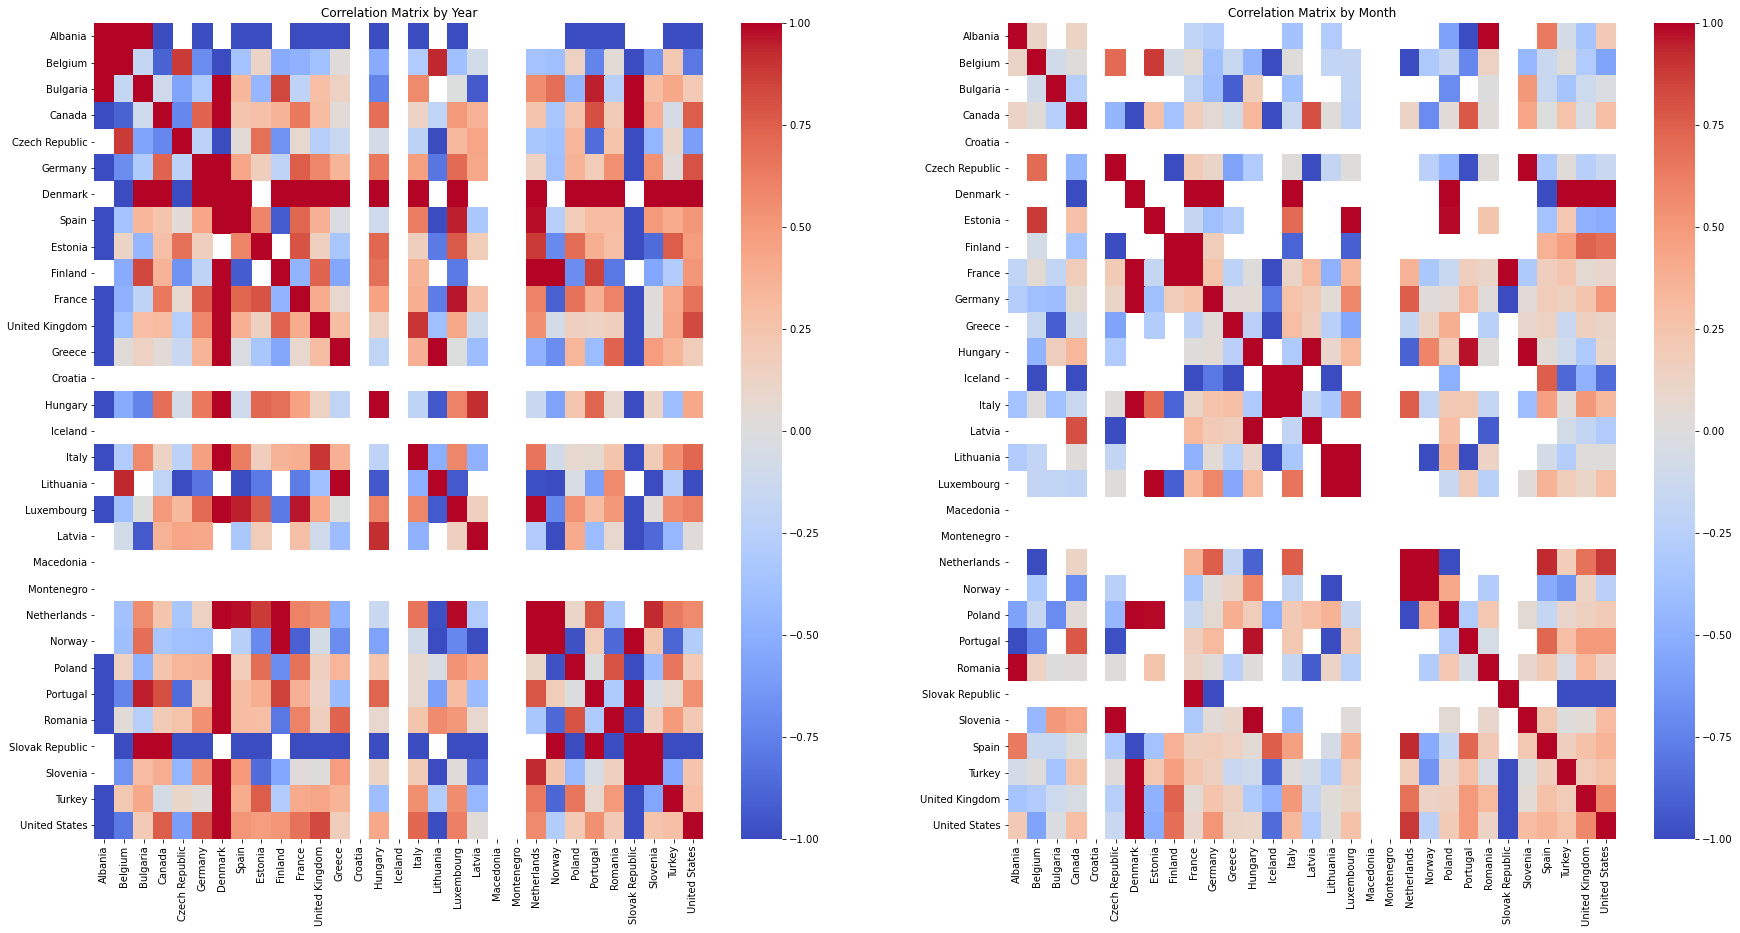

In [80]:
import seaborn as sns
import matplotlib. pyplot as plt 

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(30,15))

# By Year
numeric_cols = nato_year_df.select_dtypes(include=['float64', 'int64']).columns
df_numeric = nato_year_df[numeric_cols]

# transpose the DataFrame
df_t = df_numeric.T

# compute the correlation matrix
corr_matrix = df_t.corr()

# plot the heatmap
sns.heatmap(corr_matrix, cmap='coolwarm', ax=ax1)

# By Month
numeric_cols = nato_month_df.select_dtypes(include=['float64', 'int64']).columns
df_numeric = nato_month_df[numeric_cols]

# transpose the DataFrame
df_t = df_numeric.T

# compute the correlation matrix
corr_matrix = df_t.corr()

# plot the heatmap
sns.heatmap(corr_matrix, cmap='coolwarm', ax=ax2)

ax1.title.set_text('Correlation Matrix by Year')
ax2.title.set_text('Correlation Matrix by Month')
plt.show()



#### Drop any rows with NaN values in the tone columns

#save csv
nato_year_df.to_csv('./csv/nato_year_df.csv')

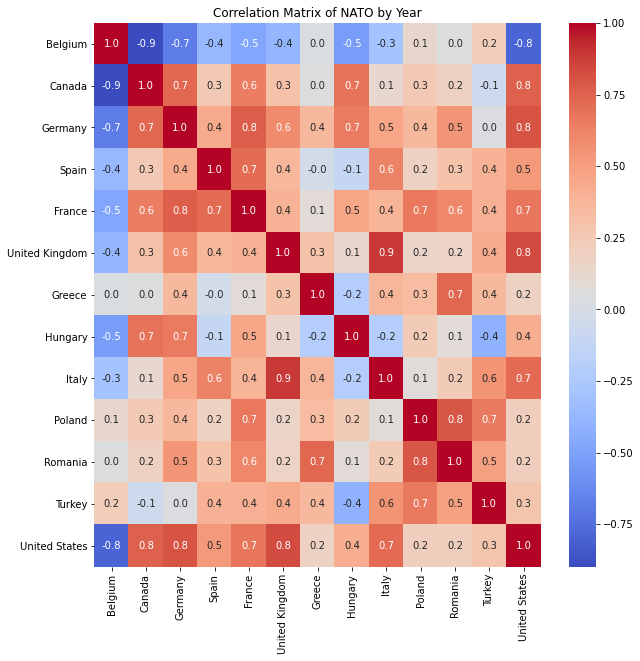

In [81]:
# Drop rows as long as NaN is present in any of the tone columns
temp_df = nato_year_df.dropna(subset=nato_year_df.columns[3:])

# melt the dataframe to long format
melted_df = pd.melt(temp_df.reset_index(), id_vars=['index', 'ISO3', 'Region', 'Sub-region'], var_name='Year', value_name='Tone')
melted_df = melted_df.set_index('index')

# create the line chart
fig = px.line(melted_df, x='Year', y='Tone', color=melted_df.index, title='Average Tone by NATO Countries by Year')
fig.show()



# By Year
numeric_cols = temp_df.select_dtypes(include=['float64', 'int64']).columns
df_numeric = temp_df[numeric_cols]

# transpose the DataFrame
df_t = df_numeric.T

# compute the correlation matrix
corr_matrix = df_t.corr()

# plot the heatmap
plt.figure(figsize=(10,10))
plt.title('Correlation Matrix of NATO by Year')
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".1f")

plt.show()


In [82]:
fig = px.scatter(melted_df, x="Year", y="Tone", color=melted_df.index, title="Average Tone by NATO Countries by Year")
fig.show()

#### Show percentage change per year

In [83]:
cm = sns.light_palette("green", as_cmap=True)

In [84]:
diff_df = nato_year_df.iloc[:,3:].diff(axis=1)

# Drop the first column since there's no previous year to compare
diff_df = diff_df.drop(columns=['2017'])

def color_negative_red(val):
    color = 'red' if val < 0 else 'green' if val > 0  else 'grey'
    return f'background-color: {color}'

diff_df.style.applymap(color_negative_red)



,2018,2019,2020,2021,2022,2023
Albania,nan,nan,nan,nan,nan,nan
Belgium,2.947917,0.952083,0.730000,-0.749048,-2.714286,0.500000
Bulgaria,-3.166667,0.666667,0.000000,nan,nan,-8.000000
Canada,-1.110606,-0.764409,-0.007392,0.826471,0.231399,0.516204
Czech Republic,2.500000,0.166667,nan,nan,-1.380952,1.380952
Germany,-0.113161,-1.932744,-0.338065,0.032084,0.559506,1.650845
Denmark,nan,nan,nan,nan,nan,nan
Spain,0.925893,-1.053598,-2.765152,2.100000,0.400000,-1.250000
Estonia,nan,0.000000,-1.000000,1.500000,-1.166667,nan
Finland,-11.000000,8.000000,nan,nan,nan,nan
